In [ ]:
# !pip install python-mnist

In [1]:
from mnist import MNIST
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
mndata = MNIST(r'/Users/lalitsachan/Dropbox/DLV1/mnist_data')
images_train, labels_train = mndata.load_training()
images_test,labels_test=mndata.load_testing()

In [3]:
labels_train=np.array(labels_train).reshape(-1,1)
labels_test=np.array(labels_test).reshape(-1,1)

In [4]:
onehot=OneHotEncoder()
onehot.fit(labels_train)
labels_train=onehot.transform(labels_train)
labels_test=onehot.transform(labels_test)
labels_train=labels_train.toarray()
labels_test=labels_test.toarray()
images_train=np.array(images_train).reshape(60000,784)
images_test=np.array(images_test).reshape(10000,784)
images_train=images_train/255
images_test=images_test/255

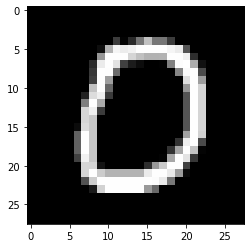

real label: 0


In [5]:
ind=10
sample_image = images_test[ind] 
sample_image = np.array(sample_image, dtype='float')
pixels = sample_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
print('real label:',np.argmax(labels_test[ind]))

In [6]:
# def weight_variable(shape):
#     initial = tf.random.truncated_normal(shape,stddev=0.1,mean=0.0)
#     return tf.Variable(initial)

# def bias_variable(shape):
#     initial = tf.random.truncated_normal(shape,stddev=0.1,mean=0.0)
#     return tf.Variable(initial)

# def conv2d(x, W):
#     return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# def max_pool_2x2(x):
#     return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
#                         strides=[1, 2, 2, 1], padding='SAME')

In [13]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32]))
b_conv1 = tf.Variable(tf.random.truncated_normal([32]))


W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64]))
b_conv2 = tf.Variable(tf.random.truncated_normal([64]))


W_fc1 = tf.Variable(tf.random.truncated_normal([7*7*64, 1024]))
b_fc1 = tf.Variable(tf.random.truncated_normal([1024]))


keep_prob = tf.constant(0.2,'float32')


W_fc2 =tf.Variable(tf.random.truncated_normal([1024, 200]))
b_fc2 = tf.Variable(tf.random.truncated_normal([200]))


W_fc3 = tf.Variable(tf.random.truncated_normal([200, 10]))
b_fc3 = tf.Variable(tf.random.truncated_normal([10]))


In [14]:
def model(x,keep_prob):
    x_image=tf.cast(tf.reshape(x, [-1, 28, 28, 1]),'float32')
        
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
   
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    
    h_fc2= tf.nn.tanh(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    h_fc2_drop=tf.nn.dropout(h_fc2,keep_prob)
    
    y_conv_logits=tf.matmul(h_fc2_drop, W_fc3) + b_fc3
    
    return y_conv_logits
    

In [15]:
def cross_entropy(y_true, y_pred):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    return tf.reduce_mean(loss)

def accuracy(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=1), dtype=tf.int32)
    preds = tf.cast(tf.argmax(y_pred, axis=1), dtype=tf.int32)
    preds = tf.equal(y_true, preds)
    return tf.reduce_mean(tf.cast(preds, dtype=tf.float32))


def grad(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x,keep_prob)
        loss_val = cross_entropy(y, y_pred)
    gradients=tape.gradient(loss_val, [W_conv1,b_conv1,W_conv2,b_conv2,W_fc1,b_fc1,W_fc2,b_fc2,W_fc3,b_fc3])
    return(gradients)

In [16]:
epochs=1000


In [17]:
learning_rate=0.01
for epoch in range(epochs):
    rand_int=np.random.choice(range(60000),10)
    x_train_batch=images_train[rand_int]
    y_train_batch=labels_train[rand_int]
    
    dw_conv1,db_conv1,dw_conv2,db_conv2,dw_fc1,db_fc1,dw_fc2,db_fc2,dw_fc3,db_fc3=grad(x_train_batch,tf.cast(y_train_batch,'float32'))
    
    W_conv1.assign_sub(learning_rate*dw_conv1)
    W_conv2.assign_sub(learning_rate*dw_conv2)
    W_fc1.assign_sub(learning_rate*dw_fc1)
    W_fc2.assign_sub(learning_rate*dw_fc2)
    W_fc3.assign_sub(learning_rate*dw_fc3)
    
    b_conv1.assign_sub(learning_rate*db_conv1)
    b_conv2.assign_sub(learning_rate*db_conv2)
    b_fc1.assign_sub(learning_rate*db_fc1)
    b_fc2.assign_sub(learning_rate*db_fc2)
    b_fc3.assign_sub(learning_rate*db_fc3)
    
    if epoch%50==0:
    
        test_pred=model(images_test,tf.constant(0.0,'float32'))
        acc_test=accuracy(labels_test,test_pred).numpy()
        loss_test=cross_entropy(labels_test,test_pred).numpy()


        train_pred=model(images_train,tf.constant(0.0,'float32'))
        acc_train=accuracy(labels_train,train_pred).numpy()
        loss_train=cross_entropy(labels_train,train_pred).numpy()
        print(acc_test,loss_test,' &&& ',acc_train,loss_train)
    
#     if loss_train<3:
#         learning_rate=20

0.1248 14.0201645  &&&  0.123066664 14.208666
0.1053 18.217566  &&&  0.10571667 18.065838
0.1186 11.156509  &&&  0.11793333 11.057397
0.1344 8.672135  &&&  0.13488333 8.629986
0.1168 8.834539  &&&  0.11661667 8.752362
0.1169 8.93902  &&&  0.11676667 8.855887
0.126 8.339576  &&&  0.12551667 8.280966
0.1181 7.822731  &&&  0.11636667 7.765934
0.1173 7.718269  &&&  0.11595 7.6542683
0.1108 7.735453  &&&  0.111316666 7.6442127


KeyboardInterrupt: 